In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [2]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)
(800,)


# Model Implementation

In [4]:
def gini(sequence):
    unique, counts = np.unique(sequence, return_counts=True)
    s = np.sum(counts)
    result = 0
    for c in counts:
        result += (c/s)**2
    
    return 1 - result


def entropy(sequence):
    unique, counts = np.unique(sequence, return_counts=True)
    s = np.sum(counts)
    result = 0
    for c in counts:
        result += (c/s) * np.log2(c/s)
    
    return -result

In [5]:
class Tree():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, pred, depth):
        self.pred = pred
        self.attribute = ''
        self.threshold = 0
        self.left_child = None
        self.right_child = None
        self.depth = depth


In [6]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        
        """
            You can add/change any variables/methods to meet your need.
        """
        self.root = None
        self.num_attr = 0

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth

        self.importance = {}
        self.max_features = max_features

    def split(self, X, y):
        best_attr = -1
        best_thres = -1e9
        X_tmp = np.column_stack((X, y))
        
        min_ent = self.criterion(y)
        
        attr_list = range(self.num_attr)
        if self.max_features != None:
            attr_list = np.random.choice(attr_list, size=self.max_features, replace=False)
            
        for attr in attr_list:
            res = X_tmp[X_tmp[:, attr].argsort()]

            for thres_idx in range(1, len(res)):
                thres = res[:, attr][thres_idx]
                left_index = np.where(res[:, attr] < thres)
                left = res[left_index]
                right_index = np.where(res[:, attr] >= thres)
                right = res[right_index]
                left_ent = self.criterion(left[:,self.num_attr])
                right_ent = self.criterion(right[:,self.num_attr])
                total_ent = left_ent * (len(left)/len(res)) + right_ent * (len(right)/len(res))
                if total_ent < min_ent:
                    min_ent = total_ent
                    best_attr = attr
                    best_thres = thres
            
        
        return best_attr, best_thres
        
    def build(self, X, y, depth):
        unique, counts = np.unique(y, return_counts=True)
        pred = unique[np.argmax(counts)]
        node = Tree(pred, depth)
        
        if self.max_depth == 1e9 or depth < self.max_depth:
            attr, thres = self.split(X, y)
            
            if attr != -1:
                left_index = np.where(X[:, attr] < thres)
                X_left = X[left_index]
                y_left = y[left_index]
                right_index = np.where(X[:, attr] >= thres)
                X_right = X[right_index]
                y_right = y[right_index]
                
                node.attribute = attr
                node.threshold = thres
                self.importance[attr] += 1
                node.left_child = self.build(X_left, y_left, depth+1)
                node.right_child = self.build(X_right, y_right, depth+1)
            
        return node

    def fit(self, X, y, sample_weight=None):
        self.num_attr = X.shape[1]
        self.importance = [0] * self.num_attr
        self.root = self.build(X, y, 0)

    def predict(self, X):
        y_pred = []
        for item in X:
            curr_node = self.root
            while True:
                if curr_node.left_child == None or curr_node.right_child == None:
                    break
                
                if item[curr_node.attribute] < curr_node.threshold:
                    curr_node = curr_node.left_child
                else:
                    curr_node = curr_node.right_child
            
            y_pred.append(curr_node.pred)
        
        return np.array(y_pred)
        

    def countImportance(self):
        pass

In [7]:
class RandomForest():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
        self.n_estimators = n_estimators
        if max_features != None:
            self.max_features = int(max_features)
        else:
            self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        for _ in range(self.n_estimators):
            if self.boostrap:
                idxs = range(len(X))
                idxs = np.random.choice(idxs, size=int(len(X)/2), replace=False)
                X_sub = X[idxs]
                y_sub = y[idxs]
            
            tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            tree.fit(X_sub, y_sub)
            self.trees.append(tree)

    def predict(self, X):
        # majority vote
        total_pred = []
        for tree in self.trees:
            y_pred = tree.predict(X)
            total_pred.append(y_pred)
        
        total_pred = np.array(total_pred)
        y_pred = []
        for i in range(len(X)):
            unique, counts = np.unique(total_pred[:, i], return_counts=True)
            pred = unique[np.argmax(counts)]
            y_pred.append(pred)
            
        return np.array(y_pred)

# Questions for Decision Tree

In [8]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [9]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train, sample_weight=None)

acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.7325


In [10]:
"""
    Updated as of 20:30 on Apr. 22.
    The accuracy assertion has been removed. However, you can still use Sklearn's accuracy metric to evaluate the correctness of your implementation.
"""

# """ Do Not Modify Below """

# from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

# sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
# sk_dt.fit(X_train, y_train)
# sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))

# assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

"\n    Updated as of 20:30 on Apr. 22.\n    The accuracy assertion has been removed. However, you can still use Sklearn's accuracy metric to evaluate the correctness of your implementation.\n"

In [11]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train, sample_weight=None)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.855


In [12]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train, sample_weight=None)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))


Q3-1 criterion='gini':  0.7325


In [13]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train, sample_weight=None)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.77


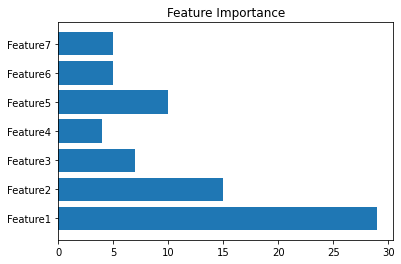

In [14]:
# For Q4

# Use simply counting to get the feature importance: dt_depth10.importance

labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']

plt.title('Feature Importance')
plt.barh(labelList, dt_depth10.importance)
plt.show()

# Questions for Random Rorest

In [15]:
# For Q5-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q6-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q6-1 n_estimators=10:  0.8975


In [16]:
# For Q5-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(0)

rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q6-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q6-1 n_estimators=50:  0.89625


In [17]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q7-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q7-1 max_features='sqrt':  0.8975


In [18]:
# For Q6-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(0)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q7-1 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q7-1 max_features='All':  0.875


# Train your own model

In [19]:
# Build and train your model

In [20]:
X_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))
print(X_all.shape)
print(y_all.shape)

(1600, 7)
(1600,)


In [21]:
"""
    Updated as of 20:30 on Apr. 22.
    We have modified the baseline score, please check the HW3 slide.
"""

'\n    Updated as of 20:30 on Apr. 22.\n    We have modified the baseline score, please check the HW3 slide.\n'

In [22]:
my_model = RandomForest(n_estimators=50, max_features=np.sqrt(X_all.shape[1]), boostrap=True, criterion='gini', max_depth=None)
my_model.fit(X_all, y_all)
print("my model n_estimators=50: ", accuracy_score(y_val, my_model.predict(X_val)))

test_pred = my_model.predict(X_test)
test_pred = np.expand_dims(test_pred, axis=1)
print("test_pred shape: ", test_pred.shape)

my model n_estimators=50:  0.99625
test_pred shape:  (800, 1)


In [23]:
# output csv
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("sample_output.csv")